# Previsione del Totale (kg) in Gara di Powerlifting  
**Progetto di Machine Learning – Previsione delle Performance Atletiche**

**Realizzato da:** Pietro Sbaraccani  
**pietro.sbaraccani@studio.unibo.it**  

---

## Introduzione

L'obiettivo di questo progetto è costruire un modello di regressione in grado di **prevedere il totale sollevato (in kg) da un atleta di powerlifting** in una gara, basandosi esclusivamente sulle sue **caratteristiche personali**, il **tipo di competizione** e i **primi tentativi (openers)** nei tre sollevamenti principali: squat, panca e stacco da terra.

Questa previsione può risultare utile sia per atleti che desiderano stimare le proprie potenzialità in gara, sia per coach e analisti sportivi che vogliono ottimizzare le strategie di gara.

---

## Caricamento delle librerie

Per cominciare, importiamo le principali librerie necessarie per l’analisi e la modellazione dei dati:

- `NumPy` per la gestione di array e operazioni numeriche;
- `pandas` per la manipolazione e analisi di dati tabulari;
- `matplotlib` e `seaborn` per la visualizzazione grafica;
- `scikit-learn` per la costruzione e valutazione dei modelli di machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

print("ANALISI COMPLETA DATASET POWERLIFTING - PREDIZIONE TOTAL")

ANALISI COMPLETA DATASET POWERLIFTING - PREDIZIONE TOTAL


## Caricamento del Dataset OpenPowerlifting

In questa sezione viene effettuato il **caricamento iniziale** del dataset `openpowerlifting.csv`, contenente i risultati di competizioni di powerlifting provenienti da tutto il mondo. Per motivi di prestazioni e test, il caricamento è limitato a un **campione di 50.000 righe**.


In [2]:
try:
    # Carica dataset completo o sample per test
    df = pd.read_csv('openpowerlifting.csv', low_memory=False, nrows=50000)
    print(f"Dataset caricato: {len(df)} righe, {len(df.columns)} colonne")
    print(f"Colonne disponibili: {list(df.columns)}")
except Exception as e:
    print(f"Errore nel caricamento: {e}")
    exit()

# Informazioni generali sul dataset
print(f"\nINFORMAZIONI GENERALI:")
print(f"   Dimensioni: {df.shape}")
print(f"   Memoria utilizzata: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"   Tipi di dati: {df.dtypes.value_counts().to_dict()}")

Dataset caricato: 50000 righe, 37 colonne
Colonne disponibili: ['Name', 'Sex', 'Event', 'Equipment', 'Age', 'AgeClass', 'Division', 'BodyweightKg', 'WeightClassKg', 'Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'Squat4Kg', 'Best3SquatKg', 'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Bench4Kg', 'Best3BenchKg', 'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Deadlift4Kg', 'Best3DeadliftKg', 'TotalKg', 'Place', 'Wilks', 'McCulloch', 'Glossbrenner', 'IPFPoints', 'Tested', 'Country', 'Federation', 'Date', 'MeetCountry', 'MeetState', 'MeetName']

INFORMAZIONI GENERALI:
   Dimensioni: (50000, 37)
   Memoria utilizzata: 52.1 MB
   Tipi di dati: {dtype('float64'): 22, dtype('O'): 15}


## Caricamento del Dataset OpenPowerlifting [COMPLETO]

In questa sezione viene effettuato il **caricamento iniziale** del dataset `openpowerlifting.csv`, contenente i risultati di competizioni di powerlifting provenienti da tutto il mondo.valide in gara


In [3]:
try:
    # Carica dataset completo
    df = pd.read_csv('openpowerlifting.csv', low_memory=False)
    print(f"Dataset caricato: {len(df)} righe, {len(df.columns)} colonne")
    print(f"Colonne disponibili: {list(df.columns)}")
except Exception as e:
    print(f"Errore nel caricamento: {e}")
    exit()

# Informazioni generali sul dataset
print(f"\nINFORMAZIONI GENERALI:")
print(f"   Dimensioni: {df.shape}")
print(f"   Memoria utilizzata: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"   Tipi di dati: {df.dtypes.value_counts().to_dict()}")

Dataset caricato: 1423354 righe, 37 colonne
Colonne disponibili: ['Name', 'Sex', 'Event', 'Equipment', 'Age', 'AgeClass', 'Division', 'BodyweightKg', 'WeightClassKg', 'Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'Squat4Kg', 'Best3SquatKg', 'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Bench4Kg', 'Best3BenchKg', 'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Deadlift4Kg', 'Best3DeadliftKg', 'TotalKg', 'Place', 'Wilks', 'McCulloch', 'Glossbrenner', 'IPFPoints', 'Tested', 'Country', 'Federation', 'Date', 'MeetCountry', 'MeetState', 'MeetName']

INFORMAZIONI GENERALI:
   Dimensioni: (1423354, 37)
   Memoria utilizzata: 1463.1 MB
   Tipi di dati: {dtype('float64'): 22, dtype('O'): 15}


## Analisi dei Valori Mancanti.

Il codice seguente calcola:

- Il numero assoluto di valori mancanti per ciascuna colonna
- La percentuale rispetto al totale delle righe del dataset

In [4]:
print("VALORI MANCANTI:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Colonna': missing_data.index,
    'Valori_Mancanti': missing_data.values,
    'Percentuale': missing_percent.values
}).sort_values('Percentuale', ascending=False)

print(missing_df[missing_df['Valori_Mancanti'] > 0].head(10))

VALORI MANCANTI:
        Colonna  Valori_Mancanti  Percentuale
12     Squat4Kg          1419658    99.740332
22  Deadlift4Kg          1414108    99.350408
17     Bench4Kg          1413849    99.332211
11     Squat3Kg          1099512    77.247965
10     Squat2Kg          1090005    76.580036
9      Squat1Kg          1085774    76.282780
21  Deadlift3Kg          1083407    76.116483
20  Deadlift2Kg          1067331    74.987038
19  Deadlift1Kg          1059810    74.458638
31      Country          1034470    72.678336


## Applicazione di Filtri per Ottenere Dati Utilizzabili

Il dataset grezzo contiene molte osservazioni non valide o incomplete che devono essere rimosse prima di poter costruire un modello affidabile. In questa fase abbiamo applicato una serie di filtri logici e qualitativi per ottenere un sottoinsieme di dati coerente e utilizzabile per l'analisi:

1. **Filtro per tipo di attrezzatura**  
   Sono stati mantenuti solo i record relativi a competizioni con attrezzatura standard:  
   `'Raw'`, `'Single-ply'` e `'Multi-ply'`.

2. **Filtro per sesso valido**  
   Sono stati considerati solo gli atleti con sesso specificato come `'M'` o `'F'`.

3. **Presenza dei tentativi iniziali e del totale**  
   Sono stati eliminati i record che non contengono almeno i primi tentativi delle tre alzate (`Squat1Kg`, `Bench1Kg`, `Deadlift1Kg`) e il totale sollevato (`TotalKg`).

4. **Filtri su valori realistici delle alzate**  
   Sono stati esclusi i record contenenti valori anomali:
   - Squat: tra 0 e 600 kg  
   - Bench: tra 0 e 400 kg  
   - Deadlift: tra 0 e 500 kg  
   - Totale: tra 0 e 1200 kg

5. **Controllo di coerenza sul totale**  
   È stato infine applicato un controllo logico sulla somma delle tre alzate: la differenza tra `TotalKg` e la somma dei primi tentativi non deve superare i **100 kg**.


In [5]:
print("APPLICAZIONE FILTRI PER DATI UTILIZZABILI:")

initial_count = len(df)
print(f"   Dataset iniziale: {initial_count} righe")

# Mantieni solo competizioni con equipment standard
valid_equipment = ['Raw', 'Single-ply', 'Multi-ply']
df_clean = df[df['Equipment'].isin(valid_equipment)].copy()
print(f"   Dopo filtro Equipment: {len(df_clean)} righe (-{initial_count - len(df_clean)})")

# Mantieni solo sessi validi
df_clean = df_clean[df_clean['Sex'].isin(['M', 'F'])]
print(f"   Dopo filtro Sex: {len(df_clean)} righe")

# Rimuovi record senza alzate principali
required_lifts = ['Squat1Kg', 'Bench1Kg', 'Deadlift1Kg', 'TotalKg']
df_clean = df_clean.dropna(subset=required_lifts)
print(f"   Dopo rimozione NaN alzate: {len(df_clean)} righe")

# Filtri per valori realistici
df_clean = df_clean[
    (df_clean['Squat1Kg'] > 0) & (df_clean['Squat1Kg'] < 600) &
    (df_clean['Bench1Kg'] > 0) & (df_clean['Bench1Kg'] < 400) &
    (df_clean['Deadlift1Kg'] > 0) & (df_clean['Deadlift1Kg'] < 500) &
    (df_clean['TotalKg'] > 0) & (df_clean['TotalKg'] < 1200)
]
print(f"   Dopo filtri valori realistici: {len(df_clean)} righe")

# Filtro consistenza logica (Total ≈ somma alzate)
sum_lifts = df_clean['Squat1Kg'] + df_clean['Bench1Kg'] + df_clean['Deadlift1Kg']
diff_total = abs(df_clean['TotalKg'] - sum_lifts)
df_clean = df_clean[diff_total < 100]  # Max 100kg differenza
print(f"   Dopo controllo consistenza: {len(df_clean)} righe")
print(f"   Righe rimosse totali: {initial_count - len(df_clean)} ({(initial_count - len(df_clean))/initial_count*100:.1f}%)")

APPLICAZIONE FILTRI PER DATI UTILIZZABILI:
   Dataset iniziale: 1423354 righe
   Dopo filtro Equipment: 1319597 righe (-103757)
   Dopo filtro Sex: 1319597 righe
   Dopo rimozione NaN alzate: 269487 righe
   Dopo filtri valori realistici: 207012 righe
   Dopo controllo consistenza: 205010 righe
   Righe rimosse totali: 1218344 (85.6%)


## Statistiche Descrittive delle Variabili Numeriche

Per comprendere meglio la distribuzione e la scala delle variabili più rilevanti per la previsione del totale sollevato (`TotalKg`), abbiamo calcolato le principali statistiche descrittive sulle seguenti colonne numeriche:

- `Squat1Kg`: carico tentato nel primo tentativo di squat  
- `Bench1Kg`: carico tentato nel primo tentativo di panca  
- `Deadlift1Kg`: carico tentato nel primo tentativo di stacco  
- `TotalKg`: somma dei migliori tre sollevamenti  
- `BodyweightKg`: peso corporeo dell'atleta  
- `Age`: età dell'atleta

Per ciascuna variabile sono stati calcolati:
- **Valori classici**: media, deviazione standard, minimi, massimi e quartili
- **Mediana**: valore centrale della distribuzione
- **Intervallo Interquartile (IQR)**: differenza tra il 75° e il 25° percentile, utile per valutare la dispersione  
- **Asimmetria (Skewness)**: indica la simmetria della distribuzione rispetto alla media (positiva = coda a destra)  
- **Curtosi (Kurtosis)**: misura la "punta" della distribuzione (valori > 0 indicano code pesanti)


In [6]:
print("STATISTICHE DESCRITTIVE VARIABILI NUMERICHE:")
numeric_cols = ['Squat1Kg', 'Bench1Kg', 'Deadlift1Kg', 'TotalKg', 'BodyweightKg', 'Age']
numeric_available = [col for col in numeric_cols if col in df_clean.columns]

stats_df = df_clean[numeric_available].describe()
print(stats_df.round(2))

# Statistiche aggiuntive
print("\nSTATISTICHE AGGIUNTIVE:")
for col in numeric_available:
    if df_clean[col].notna().sum() > 0:
        data = df_clean[col].dropna()
        print(f"{col:12} | Mediana: {data.median():7.1f} | IQR: {data.quantile(0.75) - data.quantile(0.25):7.1f} | "
              f"Skewness: {data.skew():6.2f} | Kurtosis: {data.kurtosis():6.2f}")

STATISTICHE DESCRITTIVE VARIABILI NUMERICHE:
        Squat1Kg   Bench1Kg  Deadlift1Kg    TotalKg  BodyweightKg        Age
count  205010.00  205010.00    205010.00  205010.00     204690.00  166769.00
mean      165.64     107.99       182.08     492.98         82.05      29.72
std        67.53      48.81        59.97     176.18         21.68      12.70
min         6.80       5.00         8.00      50.00         21.60       0.00
25%       112.50      67.50       132.50     347.50         65.80      20.50
50%       160.00     105.00       180.00     490.00         80.80      25.50
75%       206.38     140.00       225.00     610.00         94.00      36.50
max       492.15     375.00       410.00    1192.95        242.40      95.50

STATISTICHE AGGIUNTIVE:
Squat1Kg     | Mediana:   160.0 | IQR:    93.9 | Skewness:   0.62 | Kurtosis:   0.26
Bench1Kg     | Mediana:   105.0 | IQR:    72.5 | Skewness:   0.65 | Kurtosis:   0.36
Deadlift1Kg  | Mediana:   180.0 | IQR:    92.5 | Skewness:   0.17 |

## Distribuzione delle Variabili Categoriali

Al fine di comprendere meglio la composizione del dataset, è utile esaminare la distribuzione delle principali **variabili categoriche** selezionate per l'analisi:

- `Sex`: sesso dell’atleta (`M` = maschio, `F` = femmina)
- `Equipment`: tipo di attrezzatura usata in gara (`Raw`, `Single-ply`, `Multi-ply`)
- `Tested`: indica se l’atleta ha partecipato a una gara testata antidoping (`Yes` / `No`)

Per ciascuna di queste variabili, vengono riportate:
- Le **frequenze assolute**: numero di osservazioni per ciascuna categoria
- Le **percentuali relative**: incidenza percentuale di ciascuna categoria sul totale

In [7]:
print("VARIABILI CATEGORICHE:")
categorical_cols = ['Sex', 'Equipment', 'Tested']
for col in categorical_cols:
    if col in df_clean.columns:
        print(f"\n{col}:")
        value_counts = df_clean[col].value_counts()
        percentages = df_clean[col].value_counts(normalize=True) * 100
        for val, count in value_counts.items():
            print(f"   {val}: {count} ({percentages[val]:.1f}%)")

VARIABILI CATEGORICHE:

Sex:
   M: 139627 (68.1%)
   F: 65383 (31.9%)

Equipment:
   Raw: 129948 (63.4%)
   Single-ply: 66105 (32.2%)
   Multi-ply: 8957 (4.4%)

Tested:
   Yes: 182096 (100.0%)


## Matrice di Correlazione

Viene ora analizzata la **matrice di correlazione** tra le principali variabili numeriche coinvolte nel modello:

- `Squat1Kg`, `Bench1Kg`, `Deadlift1Kg`: i tre tentativi di apertura (openers) per le tre alzate principali
- `TotalKg`: il totale sollevato, variabile target del nostro modello
- `BodyweightKg`: peso corporeo dell’atleta
- `Age`: età dell’atleta

La correlazione viene misurata attraverso il coefficiente di **Pearson**, che varia tra -1 (correlazione negativa perfetta) e 1 (correlazione positiva perfetta).

L’obiettivo di questa analisi è:
- Identificare **relazioni lineari** tra le variabili
- Valutare l’impatto potenziale delle feature sul totale (`TotalKg`)
- Rilevare eventuali **ridondanze** o collinearità tra le alzate individuali e `TotalKg`


In [8]:
print("MATRICE DI CORRELAZIONE:")
corr_cols = ['Squat1Kg', 'Bench1Kg', 'Deadlift1Kg', 'TotalKg']
if 'BodyweightKg' in df_clean.columns:
    corr_cols.append('BodyweightKg')
if 'Age' in df_clean.columns:
    corr_cols.append('Age')

correlation_matrix = df_clean[corr_cols].corr()
print(correlation_matrix.round(3))

MATRICE DI CORRELAZIONE:
              Squat1Kg  Bench1Kg  Deadlift1Kg  TotalKg  BodyweightKg    Age
Squat1Kg         1.000     0.907        0.916    0.972         0.606 -0.004
Bench1Kg         0.907     1.000        0.872    0.951         0.640  0.066
Deadlift1Kg      0.916     0.872        1.000    0.960         0.614  0.014
TotalKg          0.972     0.951        0.960    1.000         0.655  0.023
BodyweightKg     0.606     0.640        0.614    0.655         1.000  0.118
Age             -0.004     0.066        0.014    0.023         0.118  1.000


## Visualizzazione Esplorativa dei Dati

Per analizzare visivamente il dataset pulito, sono stati generati i seguenti grafici:

### 1. Distribuzioni delle alzate principali
I primi quattro istogrammi mostrano la distribuzione dei carichi al primo tentativo (`Squat1Kg`, `Bench1Kg`, `Deadlift1Kg`) e il totale complessivo (`TotalKg`). Permettono di osservare la forma delle distribuzioni (asimmetrie, picchi, outlier).

### 2. Boxplot per sesso
Per ciascuna delle tre alzate principali e del totale, i boxplot separati per sesso (`Sex`) mostrano differenze nei livelli di performance tra uomini e donne, evidenziando mediana, IQR e outlier.

### 3. Relazione tra alzate singole e totale
Gli scatter plot con linea di regressione lineare (in rosso tratteggiata) mostrano la relazione tra ogni singola alzata e il `TotalKg`. Le forti correlazioni visive confermano che le singole alzate sono buoni predittori del totale.

### 4. Distribuzione Equipment
Un grafico a torta rappresenta la proporzione delle tre principali categorie di `Equipment` (Raw, Single-ply, Multi-ply), mostrando la predominanza della categoria `Raw`.

### 5. Heatmap delle correlazioni
La heatmap mostra la correlazione tra le principali variabili numeriche, facilitando l’identificazione di relazioni lineari forti o deboli tra le feature (es. alzate e peso corporeo).

### 6. Età e peso corporeo
Gli ultimi istogrammi illustrano la distribuzione dell’età (`Age`) e del peso corporeo (`BodyweightKg`) degli atleti, evidenziando le fasce più rappresentate nel dataset.

### 7. Totale per Equipment
Infine, un boxplot confronta la distribuzione del `TotalKg` tra le tre tipologie di `Equipment`, suggerendo l’influenza dell’attrezzatura sui risultati totali.

Questa visualizzazione esplorativa aiuta a comprendere meglio la struttura del dataset, le relazioni tra le variabili e le potenziali feature rilevanti per la modellazione predittiva.

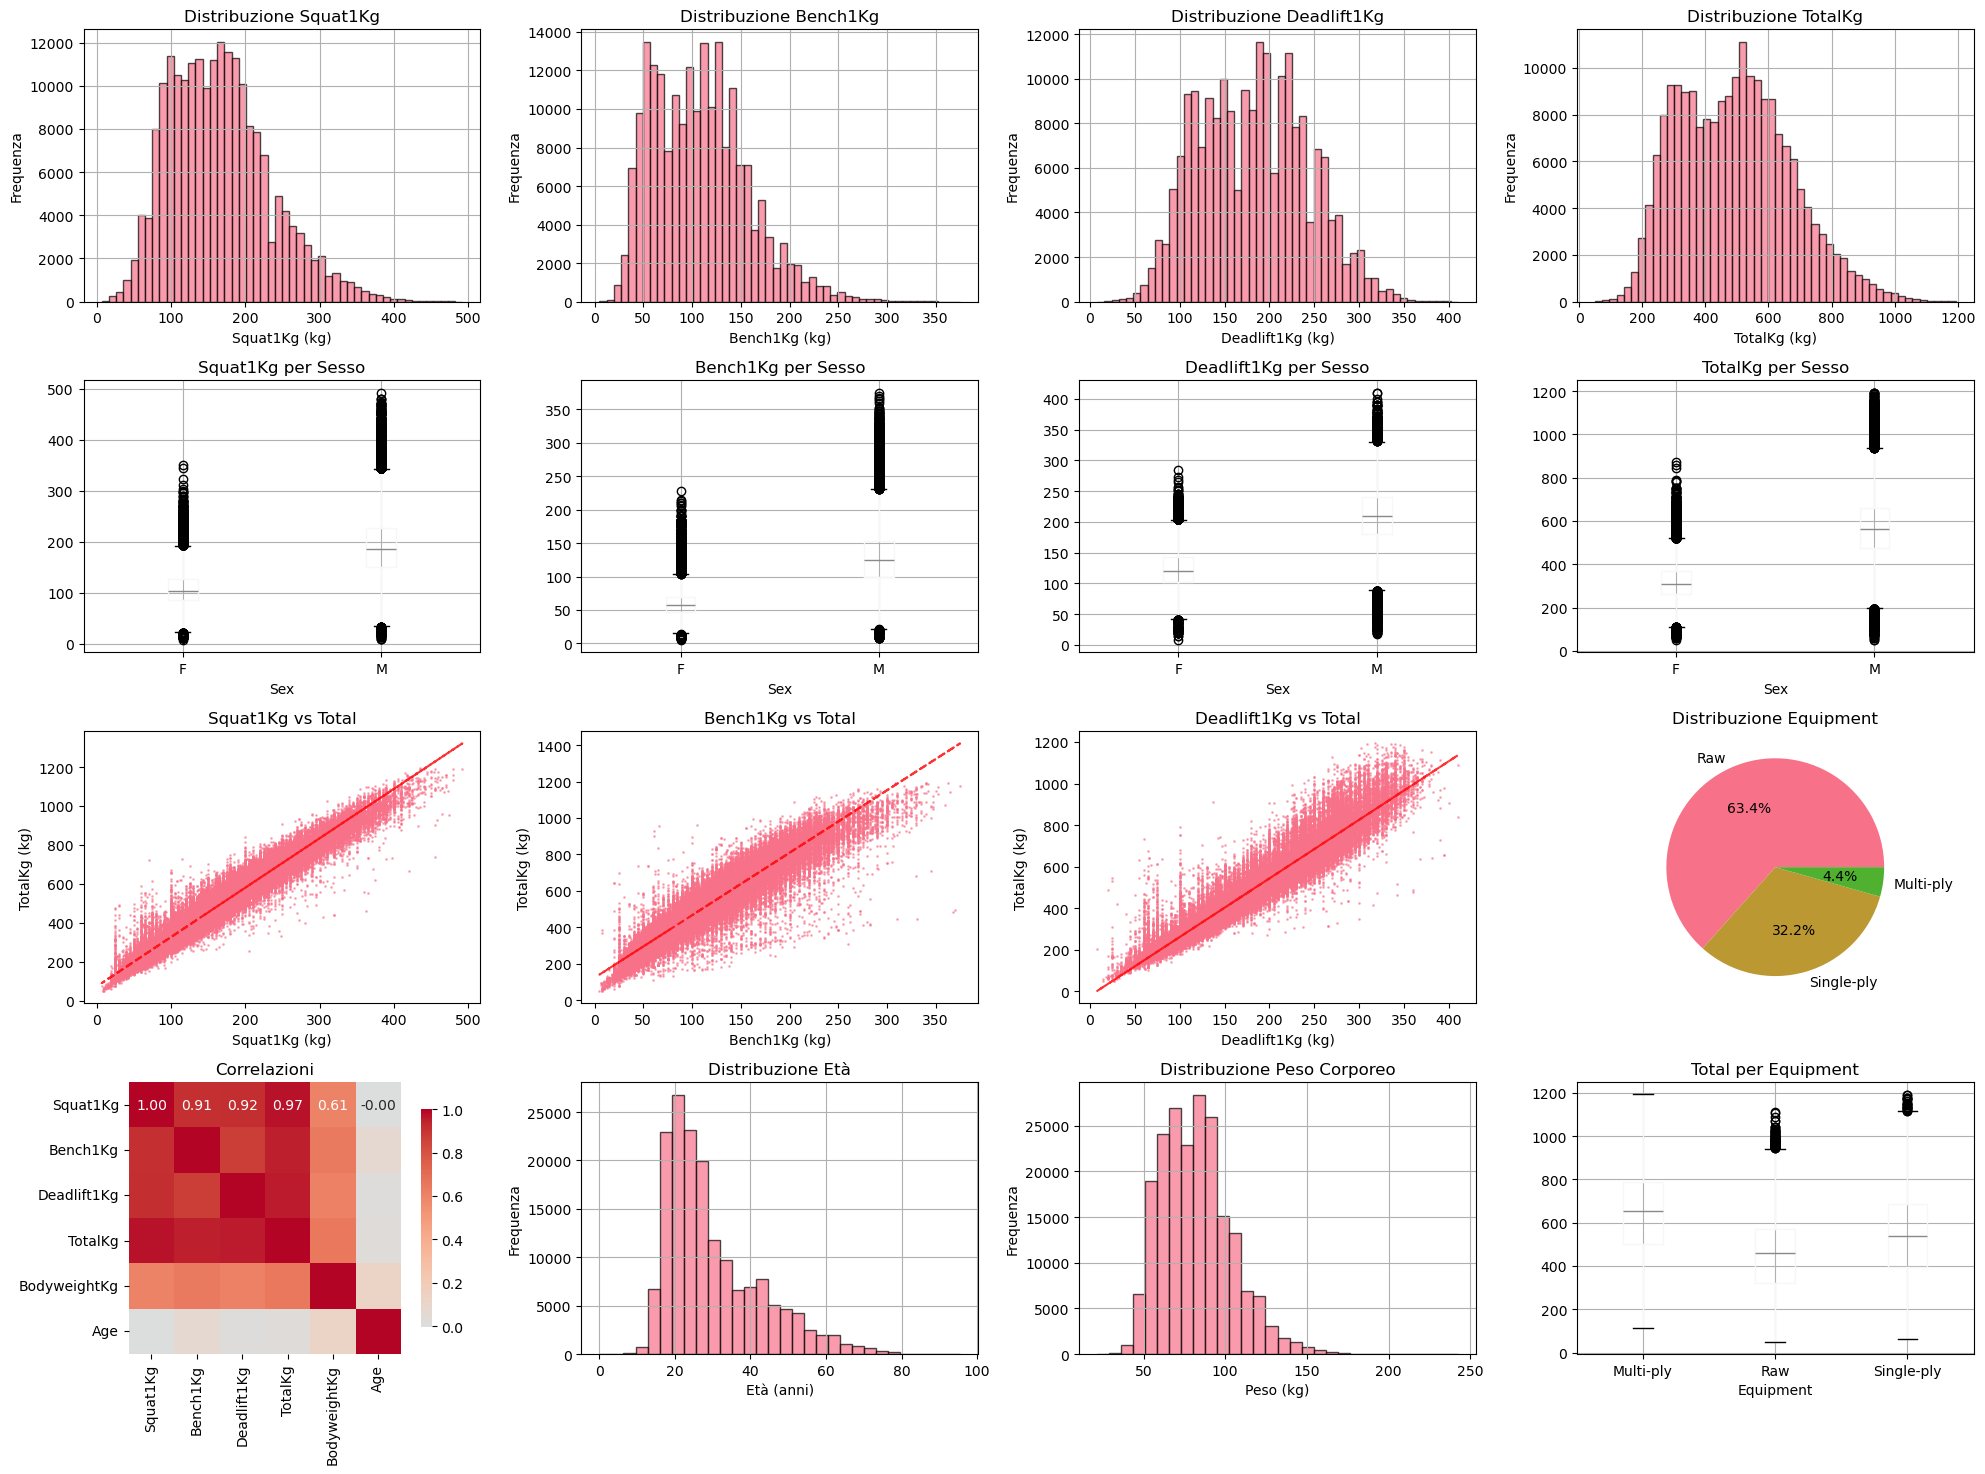

In [9]:
# Setup stile grafici
plt.style.use('default')
sns.set_palette("husl")

# Figura principale con subplot
fig = plt.figure(figsize=(20, 15))

# Istogrammi delle alzate principali
for i, col in enumerate(['Squat1Kg', 'Bench1Kg', 'Deadlift1Kg', 'TotalKg']):
    plt.subplot(4, 4, i+1)
    df_clean[col].hist(bins=50, alpha=0.7, edgecolor='black')
    plt.title(f'Distribuzione {col}')
    plt.xlabel(f'{col} (kg)')
    plt.ylabel('Frequenza')

# Boxplot per sesso
for i, col in enumerate(['Squat1Kg', 'Bench1Kg', 'Deadlift1Kg', 'TotalKg']):
    plt.subplot(4, 4, i+5)
    df_clean.boxplot(column=col, by='Sex', ax=plt.gca())
    plt.title(f'{col} per Sesso')
    plt.suptitle('')

# Scatter plots alzate vs Total
scatter_cols = ['Squat1Kg', 'Bench1Kg', 'Deadlift1Kg']
for i, col in enumerate(scatter_cols):
    plt.subplot(4, 4, i+9)
    plt.scatter(df_clean[col], df_clean['TotalKg'], alpha=0.5, s=1)
    plt.xlabel(f'{col} (kg)')
    plt.ylabel('TotalKg (kg)')
    plt.title(f'{col} vs Total')
    
    # Aggiungi linea di regressione
    z = np.polyfit(df_clean[col], df_clean['TotalKg'], 1)
    p = np.poly1d(z)
    plt.plot(df_clean[col], p(df_clean[col]), "r--", alpha=0.8)

# Grafico a torta per Equipment
plt.subplot(4, 4, 12)
equipment_counts = df_clean['Equipment'].value_counts()
plt.pie(equipment_counts.values, labels=equipment_counts.index, autopct='%1.1f%%')
plt.title('Distribuzione Equipment')

# Heatmap correlazione
plt.subplot(4, 4, 13)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlazioni')

# Distribuzione per età (se disponibile)
if 'Age' in df_clean.columns:
    plt.subplot(4, 4, 14)
    df_clean['Age'].hist(bins=30, alpha=0.7, edgecolor='black')
    plt.title('Distribuzione Età')
    plt.xlabel('Età (anni)')
    plt.ylabel('Frequenza')

# Distribuzione peso corporeo (se disponibile)
if 'BodyweightKg' in df_clean.columns:
    plt.subplot(4, 4, 15)
    df_clean['BodyweightKg'].hist(bins=30, alpha=0.7, edgecolor='black')
    plt.title('Distribuzione Peso Corporeo')
    plt.xlabel('Peso (kg)')
    plt.ylabel('Frequenza')

# Total per Equipment
plt.subplot(4, 4, 16)
df_clean.boxplot(column='TotalKg', by='Equipment', ax=plt.gca())
plt.title('Total per Equipment')
plt.suptitle('')

plt.tight_layout()
plt.show()

## Preparazione dei Dati per il Machine Learning

In questa fase, il dataset è stato preparato per l’addestramento di modelli predittivi, con particolare attenzione alla definizione delle variabili e alla gestione dei valori mancanti.

### 1. Definizione del target
Il target scelto per la previsione è `TotalKg`, ovvero il totale sollevato dall’atleta. È una variabile continua, per cui si tratta di un problema di regressione.

### 2. Selezione delle features
Sono state individuate due tipologie di feature:
- **Numeriche**: `Squat1Kg`, `Bench1Kg`, `Deadlift1Kg`, ed eventualmente `BodyweightKg` e `Age` se presenti.
- **Categoriche**: `Sex`, `Equipment`, e opzionalmente `Tested`.

Queste variabili sono ritenute predittive della performance totale dell’atleta.

### 3. Gestione dei valori mancanti
- Per le **variabili numeriche** mancanti è stata utilizzata la **mediana**, al fine di ridurre l’influenza di eventuali outlier.
- Per le **variabili categoriche** è stata utilizzata la **moda**, ovvero il valore più frequente della colonna.


In [10]:
print("PREPARAZIONE DATI PER MACHINE LEARNING")

# Definizione target e features
print("DEFINIZIONE TARGET E FEATURES:")

# Target variable
target = 'TotalKg'
y = df_clean[target].copy()
print(f"   Target: {target} (distribuzione: media={y.mean():.1f}, std={y.std():.1f})")

# Features numeriche
numeric_features = ['Squat1Kg', 'Bench1Kg', 'Deadlift1Kg']
if 'BodyweightKg' in df_clean.columns:
    numeric_features.append('BodyweightKg')
if 'Age' in df_clean.columns:
    numeric_features.append('Age')

# Features categoriche
categorical_features = ['Sex', 'Equipment']
if 'Tested' in df_clean.columns:
    categorical_features.append('Tested')

print(f"   Features numeriche: {numeric_features}")
print(f"   Features categoriche: {categorical_features}")

# Creazione dataset features
X = df_clean[numeric_features + categorical_features].copy()

# Gestione valori mancanti nelle features numeriche
for col in numeric_features:
    if X[col].isnull().any():
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)
        print(f"   Sostituiti {X[col].isnull().sum()} NaN in {col} con mediana {median_val:.1f}")

# Gestione valori mancanti nelle features categoriche
for col in categorical_features:
    if X[col].isnull().any():
        mode_val = X[col].mode()[0]
        X[col].fillna(mode_val, inplace=True)
        print(f"   Sostituiti NaN in {col} con moda '{mode_val}'")

print(f"   Dataset finale: {X.shape[0]} righe, {X.shape[1]} features")

PREPARAZIONE DATI PER MACHINE LEARNING
DEFINIZIONE TARGET E FEATURES:
   Target: TotalKg (distribuzione: media=493.0, std=176.2)
   Features numeriche: ['Squat1Kg', 'Bench1Kg', 'Deadlift1Kg', 'BodyweightKg', 'Age']
   Features categoriche: ['Sex', 'Equipment', 'Tested']
   Sostituiti 0 NaN in BodyweightKg con mediana 80.8
   Sostituiti 0 NaN in Age con mediana 25.5
   Sostituiti NaN in Tested con moda 'Yes'
   Dataset finale: 205010 righe, 8 features


## Preprocessing dei Dati e Suddivisione Train-Test

### 1. Preprocessing
Per rendere i dati compatibili con i modelli di machine learning, è stato applicato un preprocessor composto da due trasformazioni principali:

- **StandardScaler**: applicato alle variabili numeriche (`numeric_features`) per normalizzarle, cioè portarle su una scala con media 0 e deviazione standard 1.
- **OneHotEncoder**: applicato alle variabili categoriche (`categorical_features`), trasformandole in variabili binarie (dummy), escludendo la prima modalità per evitare la multicollinearità.

Il numero totale di feature risultanti dopo il preprocessing è aumentato a causa della codifica delle variabili categoriche.

### 2. Suddivisione del dataset
Il dataset è stato diviso in due sottoinsiemi:
- **Training set**: 80% dei dati, utilizzato per addestrare il modello.
- **Test set**: 20% dei dati, utilizzato per valutare le performance del modello su dati mai visti.

La divisione è stata effettuata in modo casuale, mantenendo la distribuzione naturale della variabile target `TotalKg`.

### 3. Statistiche post-split
Sono state confrontate la media e la deviazione standard del target `TotalKg` nei due sottoinsiemi per assicurarsi che la distribuzione sia simile, e che quindi la suddivisione non abbia introdotto bias.

In [11]:
print("PREPROCESSING:")

# Preprocessor per numeric e categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Test del preprocessor per vedere le colonne risultanti
X_sample = X.head(100)
X_transformed_sample = preprocessor.fit_transform(X_sample)

print(f"   StandardScaler applicato a: {numeric_features}")
print(f"   OneHotEncoder applicato a: {categorical_features}")
print(f"   Features finali dopo preprocessing: {X_transformed_sample.shape[1]}")

print(f"\nSUDDIVISIONE TRAIN-TEST:")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   Proporzione test: {len(X_test)/len(X)*100:.1f}%")

# Verifica distribuzione target dopo split
print(f"   Target train - Media: {y_train.mean():.1f}, Std: {y_train.std():.1f}")
print(f"   Target test  - Media: {y_test.mean():.1f}, Std: {y_test.std():.1f}")

PREPROCESSING:
   StandardScaler applicato a: ['Squat1Kg', 'Bench1Kg', 'Deadlift1Kg', 'BodyweightKg', 'Age']
   OneHotEncoder applicato a: ['Sex', 'Equipment', 'Tested']
   Features finali dopo preprocessing: 7

SUDDIVISIONE TRAIN-TEST:
   Training set: 164008 samples
   Test set: 41002 samples
   Proporzione test: 20.0%
   Target train - Media: 493.0, Std: 176.2
   Target test  - Media: 492.8, Std: 176.0


## Addestramento e Validazione dei Modelli di Machine Learning

### 1. Definizione dei modelli
Sono stati implementati quattro algoritmi di regressione diversi, ciascuno all'interno di una **Pipeline** che include automaticamente il preprocessing:

- **Linear Regression**: modello lineare semplice che cerca la relazione lineare tra le feature e il target
- **Ridge Regression**: versione regolarizzata della regressione lineare con parametro `alpha=1.0` per ridurre l'overfitting
- **Random Forest**: ensemble di alberi decisionali con 100 stimatori, profondità massima 10 e minimo 20 campioni per split
- **Gradient Boosting**: algoritmo di boosting con 100 stimatori, profondità 6 e learning rate 0.1

### 2. Processo di addestramento completo
Per ogni modello viene eseguito un ciclo completo che include:

- **Training**: addestramento del modello sui dati di training
- **Predizione**: generazione delle predizioni sia sui dati di training che di test
- **Calcolo delle metriche**: valutazione delle performance attraverso diverse metriche
- **Cross-validation**: validazione a 5-fold per stimare la robustezza del modello

### 3. Metriche di valutazione calcolate
Per ogni modello vengono calcolate le seguenti metriche sia su training che su test set:

- **MSE (Mean Squared Error)**: errore quadratico medio, penalizza maggiormente gli errori grandi
- **MAE (Mean Absolute Error)**: errore assoluto medio, più robusto agli outlier
- **R² (Coefficient of Determination)**: percentuale di varianza spiegata dal modello (0-1, dove 1 è perfetto)
- **Errore relativo**: errore percentuale medio rispetto ai valori reali
- **CV MSE**: MSE medio dalla cross-validation con deviazione standard

### 4. Monitoraggio delle performance temporali
Il codice traccia accuratamente i tempi di esecuzione per ogni fase:

- **Tempo di training**: quanto tempo impiega il modello ad apprendere dai dati
- **Tempo di predizione**: velocità nel generare nuove predizioni
- **Tempo di cross-validation**: durata della validazione incrociata
- **Tempo totale**: somma di tutti i tempi precedenti

In [12]:
import time

print("ADDESTRAMENTO E VALIDAZIONE MODELLI")
# Definizione modelli
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    
    'Ridge Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0, random_state=42))
    ]),
    
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, max_depth=10, 
                                          min_samples_split=20, random_state=42))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(n_estimators=100, max_depth=6, 
                                               learning_rate=0.1, random_state=42))
    ])
}

print("TRAINING MODELLI:")
results = {}
total_start_time = time.time()

for name, model in models.items():
    print(f"\n   Training {name}...")
    
    # Inizio training con tempo
    start_time = time.time()
    
    # Training
    model.fit(X_train, y_train)
    
    # Fine training
    training_time = time.time() - start_time
    
    # Predizioni
    pred_start = time.time()
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    prediction_time = time.time() - pred_start
    
    # Metriche
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Errore relativo medio
    train_rel_error = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    test_rel_error = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    # Cross-validation con tempo
    cv_start = time.time()
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                               scoring='neg_mean_squared_error')
    cv_time = time.time() - cv_start
    cv_mse = -cv_scores.mean()
    cv_std = cv_scores.std()
    
    results[name] = {
        'model': model,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rel_error': train_rel_error,
        'test_rel_error': test_rel_error,
        'cv_mse': cv_mse,
        'cv_std': cv_std,
        'predictions': y_test_pred,
        'training_time': training_time,
        'prediction_time': prediction_time,
        'cv_time': cv_time
    }
    
    print(f"      Train MSE: {train_mse:.2f} | Test MSE: {test_mse:.2f}")
    print(f"      Train MAE: {train_mae:.2f} | Test MAE: {test_mae:.2f}")
    print(f"      Train R²:  {train_r2:.3f} | Test R²:  {test_r2:.3f}")
    print(f"      Errore relativo: {test_rel_error:.2f}%")
    print(f"      CV MSE: {cv_mse:.2f} ± {cv_std:.2f}")
    print(f"      Tempo training: {training_time:.3f}s | Predizione: {prediction_time:.3f}s | CV: {cv_time:.3f}s")

total_training_time = time.time() - total_start_time
print(f"\n   TEMPO TOTALE DI ADDESTRAMENTO: {total_training_time:.3f} secondi")
print(f"   TEMPO TOTALE DI ADDESTRAMENTO: {total_training_time/60:.2f} minuti")

# Confronto tempi di training
print(f"\n{'='*60}")
print("CONFRONTO TEMPI DI TRAINING")
print(f"{'='*60}")
for name in models.keys():
    training_time = results[name]['training_time']
    prediction_time = results[name]['prediction_time']
    cv_time = results[name]['cv_time']
    total_time = training_time + prediction_time + cv_time
    
    print(f"{name:20} | Training: {training_time:7.3f}s | Predizione: {prediction_time:7.3f}s | CV: {cv_time:7.3f}s | Totale: {total_time:7.3f}s")
print(f"{'='*60}")

ADDESTRAMENTO E VALIDAZIONE MODELLI
TRAINING MODELLI:

   Training Linear Regression...
      Train MSE: 254.51 | Test MSE: 255.08
      Train MAE: 12.31 | Test MAE: 12.31
      Train R²:  0.992 | Test R²:  0.992
      Errore relativo: 2.71%
      CV MSE: 254.58 ± 2.92
      Tempo training: 0.170s | Predizione: 0.167s | CV: 0.934s

   Training Ridge Regression...
      Train MSE: 254.51 | Test MSE: 255.08
      Train MAE: 12.31 | Test MAE: 12.31
      Train R²:  0.992 | Test R²:  0.992
      Errore relativo: 2.71%
      CV MSE: 254.58 ± 2.92
      Tempo training: 0.166s | Predizione: 0.171s | CV: 0.818s

   Training Random Forest...
      Train MSE: 266.93 | Test MSE: 296.14
      Train MAE: 12.67 | Test MAE: 13.25
      Train R²:  0.991 | Test R²:  0.990
      Errore relativo: 2.91%
      CV MSE: 292.62 ± 2.22
      Tempo training: 23.451s | Predizione: 1.859s | CV: 94.586s

   Training Gradient Boosting...
      Train MSE: 244.28 | Test MSE: 259.44
      Train MAE: 12.10 | Test MAE: 

## Confronto delle Performance e Selezione del Modello Migliore

### 1. Tabella comparativa
Viene creata una tabella che confronta tutti i modelli sulle metriche principali: **MSE**, **MAE**, **R²**, **errore relativo** e **CV_MSE** sul test set.

### 2. Selezione del migliore
Il modello con **MSE più basso** sul test set viene automaticamente identificato come il migliore, poiché rappresenta la migliore accuratezza predittiva su dati mai visti.

In [13]:
print("TABELLA PERFORMANCE MODELLI:")
performance_df = pd.DataFrame({
    'Modello': list(results.keys()),
    'Test_MSE': [results[k]['test_mse'] for k in results.keys()],
    'Test_MAE': [results[k]['test_mae'] for k in results.keys()],
    'Test_R²': [results[k]['test_r2'] for k in results.keys()],
    'Errore_Rel_%': [results[k]['test_rel_error'] for k in results.keys()],
    'CV_MSE': [results[k]['cv_mse'] for k in results.keys()]
}).round(3)

print(performance_df.to_string(index=False))

# Analisi modello migliore
best_model_name = min(results.keys(), key=lambda k: results[k]['test_mse'])
best_model = results[best_model_name]['model']

print(f"\nMIGLIOR MODELLO: {best_model_name}")
print(f"    Test MSE: {results[best_model_name]['test_mse']:.3f}")
print(f"    Test R²: {results[best_model_name]['test_r2']:.3f}")
print(f"    Errore relativo: {results[best_model_name]['test_rel_error']:.2f}%")

TABELLA PERFORMANCE MODELLI:
          Modello  Test_MSE  Test_MAE  Test_R²  Errore_Rel_%  CV_MSE
Linear Regression   255.085    12.313    0.992         2.707 254.582
 Ridge Regression   255.085    12.313    0.992         2.707 254.582
    Random Forest   296.135    13.248    0.990         2.913 292.623
Gradient Boosting   259.445    12.429    0.992         2.723 258.666

MIGLIOR MODELLO: Ridge Regression
    Test MSE: 255.085
    Test R²: 0.992
    Errore relativo: 2.71%


## Analisi dell'Importanza delle Variabili

### 1. Ricostruzione dei nomi delle feature
Dopo il preprocessing, i nomi delle feature cambiano a causa del OneHotEncoding. Il codice ricostruisce la lista completa:
- **Feature numeriche**: mantengono i nomi originali
- **Feature categoriche**: vengono espanse secondo la codifica one-hot (es. "Sex_M", "Sex_F")

### 2. Estrazione dell'importanza
Il metodo varia in base al tipo di modello:
- **Tree-based models** (Random Forest, Gradient Boosting): utilizzano `feature_importances_` che indica quanto ogni feature contribuisce alle decisioni
- **Linear models** (Linear/Ridge Regression): utilizzano i `coef_` (coefficienti), dove il valore assoluto indica l'impatto sulla predizione

### 3. Ranking delle feature
Viene mostrata la **top 10** delle feature più influenti, ordinata per importanza decrescente, permettendo di identificare quali variabili hanno maggiore impatto predittivo nel modello selezionato.

In [14]:
print(f"ANALISI IMPORTANZA VARIABILI ({best_model_name}):")

# Ottieni i nomi delle feature dopo il preprocessing
best_model.fit(X_train, y_train)
feature_names_after_preprocessing = []

# Nomi delle feature numeriche (rimangono uguali)
feature_names_after_preprocessing.extend(numeric_features)

# Nomi delle feature categoriche (dopo OneHotEncoding)
if categorical_features:
    categorical_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names_after_preprocessing.extend(categorical_feature_names)

if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    # Tree-based models
    importance = best_model.named_steps['regressor'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names_after_preprocessing,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    print("   Top 10 features più importanti:")
    for _, row in feature_importance_df.head(10).iterrows():
        print(f"      {row['Feature']}: {row['Importance']:.4f}")

elif hasattr(best_model.named_steps['regressor'], 'coef_'):
    # Linear models
    coefficients = best_model.named_steps['regressor'].coef_
    coef_df = pd.DataFrame({
        'Feature': feature_names_after_preprocessing,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("   Top 10 coefficienti per valore assoluto:")
    for _, row in coef_df.head(10).iterrows():
        print(f"      {row['Feature']}: {row['Coefficient']:.4f}")

ANALISI IMPORTANZA VARIABILI (Ridge Regression):
   Top 10 coefficienti per valore assoluto:
      Squat1Kg: 67.1881
      Deadlift1Kg: 58.7484
      Bench1Kg: 49.3083
      Sex_M: 8.4770
      Equipment_Single-ply: -7.6556
      Equipment_Raw: -7.3529
      BodyweightKg: 5.0337
      Age: -0.4380


## Interpretazione dei Risultati dell'Importanza delle Variabili
### 1. Dominanza degli alzate principali
I tre lift principali sono chiaramente i predittori più importanti:

- Squat1Kg (67.19): l'alzata che contribuisce maggiormente al totale
- Deadlift1Kg (58.75): secondo contributo più significativo
- Bench1Kg (49.31): terzo in ordine di importanza

## 2. Fattori demografici e fisici

- Sex_M (8.48): essere maschio aumenta significativamente il totale previsto
- BodyweightKg (5.03): il peso corporeo ha un impatto positivo moderato
- Age (-0.44): l'età ha un piccolo effetto negativo

## 3. Effetto dell'equipaggiamento

- Equipment_Single-ply (-7.66): coefficiente negativo rispetto al riferimento
- Equipment_Raw (-7.35): anche il raw ha coefficiente negativo
- Questo suggerisce che il gruppo di riferimento (probabilmente Multi-ply) ha performance superiori

## Ottimizzazione degli Iperparametri

### 1. Selezione dei modelli da ottimizzare
Sono stati scelti **Ridge Regression** e **Random Forest** come candidati per il tuning, essendo tipicamente i più sensibili alla configurazione degli iperparametri.

### 2. Strategie di ricerca differenziate
- **Ridge Regression**: **GridSearchCV** con ricerca esaustiva su 5 valori di `alpha` (0.01-100.0) per controllare la regolarizzazione
- **Random Forest**: **RandomizedSearchCV** con 20 iterazioni su combinazioni di:
  - `n_estimators`: numero di alberi (50, 100, 200)
  - `max_depth`: profondità massima (5, 10, 15, None)
  - `min_samples_split` e `min_samples_leaf`: controlli per evitare overfitting

### 3. Validazione e confronto
Per ogni modello ottimizzato vengono calcolate:
- Le **metriche di performance** (MSE, R², MAE) sul test set
- Il **miglioramento percentuale** rispetto al modello con parametri di default
- I **migliori parametri** identificati dalla ricerca

### 4. Utilizzo di cross-validation
La **5-fold cross-validation** durante la ricerca garantisce che i parametri selezionati siano robusti e non specifici per un particolare split dei dati di training.

In [15]:
print("OTTIMIZZAZIONE IPERPARAMETRI")

# Selezioniamo Ridge e Random Forest per hyperparameter tuning
models_to_tune = ['Ridge Regression', 'Random Forest']

tuning_results = {}

for model_name in models_to_tune:
    print(f"\nTuning {model_name}...")
    
    if model_name == 'Ridge Regression':
        # Grid Search per Ridge
        base_model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', Ridge(random_state=42))
        ])
        
        param_grid = {
            'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
        
        grid_search = GridSearchCV(
            base_model, param_grid, cv=5, 
            scoring='neg_mean_squared_error', n_jobs=-1
        )
        
    elif model_name == 'Random Forest':
        # Randomized Search per Random Forest
        base_model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(random_state=42))
        ])
        
        param_dist = {
            'regressor__n_estimators': [50, 100, 200],
            'regressor__max_depth': [5, 10, 15, None],
            'regressor__min_samples_split': [10, 20, 50],
            'regressor__min_samples_leaf': [5, 10, 20]
        }
        
        grid_search = RandomizedSearchCV(
            base_model, param_dist, n_iter=20, cv=5,
            scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
        )
    
    # Esegui search
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_tuned_model = grid_search.best_estimator_
    
    # Predizioni con modello ottimizzato
    y_train_pred_tuned = best_tuned_model.predict(X_train)
    y_test_pred_tuned = best_tuned_model.predict(X_test)
    
    # Metriche modello ottimizzato
    tuned_test_mse = mean_squared_error(y_test, y_test_pred_tuned)
    tuned_test_r2 = r2_score(y_test, y_test_pred_tuned)
    tuned_test_mae = mean_absolute_error(y_test, y_test_pred_tuned)
    
    tuning_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_,
        'test_mse': tuned_test_mse,
        'test_r2': tuned_test_r2,
        'test_mae': tuned_test_mae,
        'model': best_tuned_model,
        'predictions': y_test_pred_tuned
    }
    
    print(f"      Migliori parametri: {grid_search.best_params_}")
    print(f"      CV Score: {-grid_search.best_score_:.3f}")
    print(f"      Test MSE: {tuned_test_mse:.3f}")
    print(f"      Test R²: {tuned_test_r2:.3f}")
    
    # Confronto con modello base
    original_mse = results[model_name]['test_mse']
    improvement = ((original_mse - tuned_test_mse) / original_mse) * 100
    print(f"      Miglioramento MSE: {improvement:.2f}%")

OTTIMIZZAZIONE IPERPARAMETRI

Tuning Ridge Regression...
      Migliori parametri: {'regressor__alpha': 1.0}
      CV Score: 254.582
      Test MSE: 255.085
      Test R²: 0.992
      Miglioramento MSE: 0.00%

Tuning Random Forest...
      Migliori parametri: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 5, 'regressor__max_depth': 15}
      CV Score: 267.803
      Test MSE: 263.634
      Test R²: 0.991
      Miglioramento MSE: 10.98%


In [16]:
print("RISULTATI FINALI")

# Trova il miglior modello finale (tra originali e tuned)
all_models = {**results}
for name, result in tuning_results.items():
    all_models[f"{name} (Tuned)"] = {
        'test_mse': result['test_mse'],
        'test_r2': result['test_r2'],
        'test_mae': result['test_mae'],
        'predictions': result['predictions']
    }

final_best_name = min(all_models.keys(), key=lambda k: all_models[k]['test_mse'])
final_best_predictions = all_models[final_best_name]['predictions']

print(f"MODELLO FINALE MIGLIORE: {final_best_name}")
print(f"   Test MSE: {all_models[final_best_name]['test_mse']:.3f}")
print(f"   Test MAE: {all_models[final_best_name]['test_mae']:.3f}")
print(f"   Test R²: {all_models[final_best_name]['test_r2']:.3f}")

RISULTATI FINALI
MODELLO FINALE MIGLIORE: Ridge Regression
   Test MSE: 255.085
   Test MAE: 12.313
   Test R²: 0.992


## Visualizzazioni Finali e Analisi dei Risultati

### 1. Dashboard di confronto modelli
La figura con 6 subplot fornisce una visione completa delle performance:

- **MSE e R² per modello**: confronto visivo immediato delle metriche principali
- **Scatter plot Predetto vs Reale**: valuta la precisione delle predizioni (punti vicini alla linea rossa = migliore)
- **Analisi dei residui**: scatter plot dei residui vs predizioni per identificare pattern sistematici
- **Distribuzione residui**: istogramma per verificare la normalità degli errori
- **Q-Q Plot**: test grafico per confermare la normalità dei residui

### 2. Diagnostica del modello
L'analisi dei residui è fondamentale per validare il modello:

- **Residui casuali** attorno allo zero indicano un modello ben calibrato
- **Distribuzione normale** dei residui conferma le assunzioni del modello
- **Assenza di pattern** nei residui suggerisce che il modello cattura bene la relazione

### 3. Test statistici
- **Test di Shapiro-Wilk**: verifica formalmente la normalità dei residui
- **Statistiche descrittive**: media dei residui dovrebbe essere vicina a zero
- **Range dei residui**: indica la variabilità degli errori di predizione


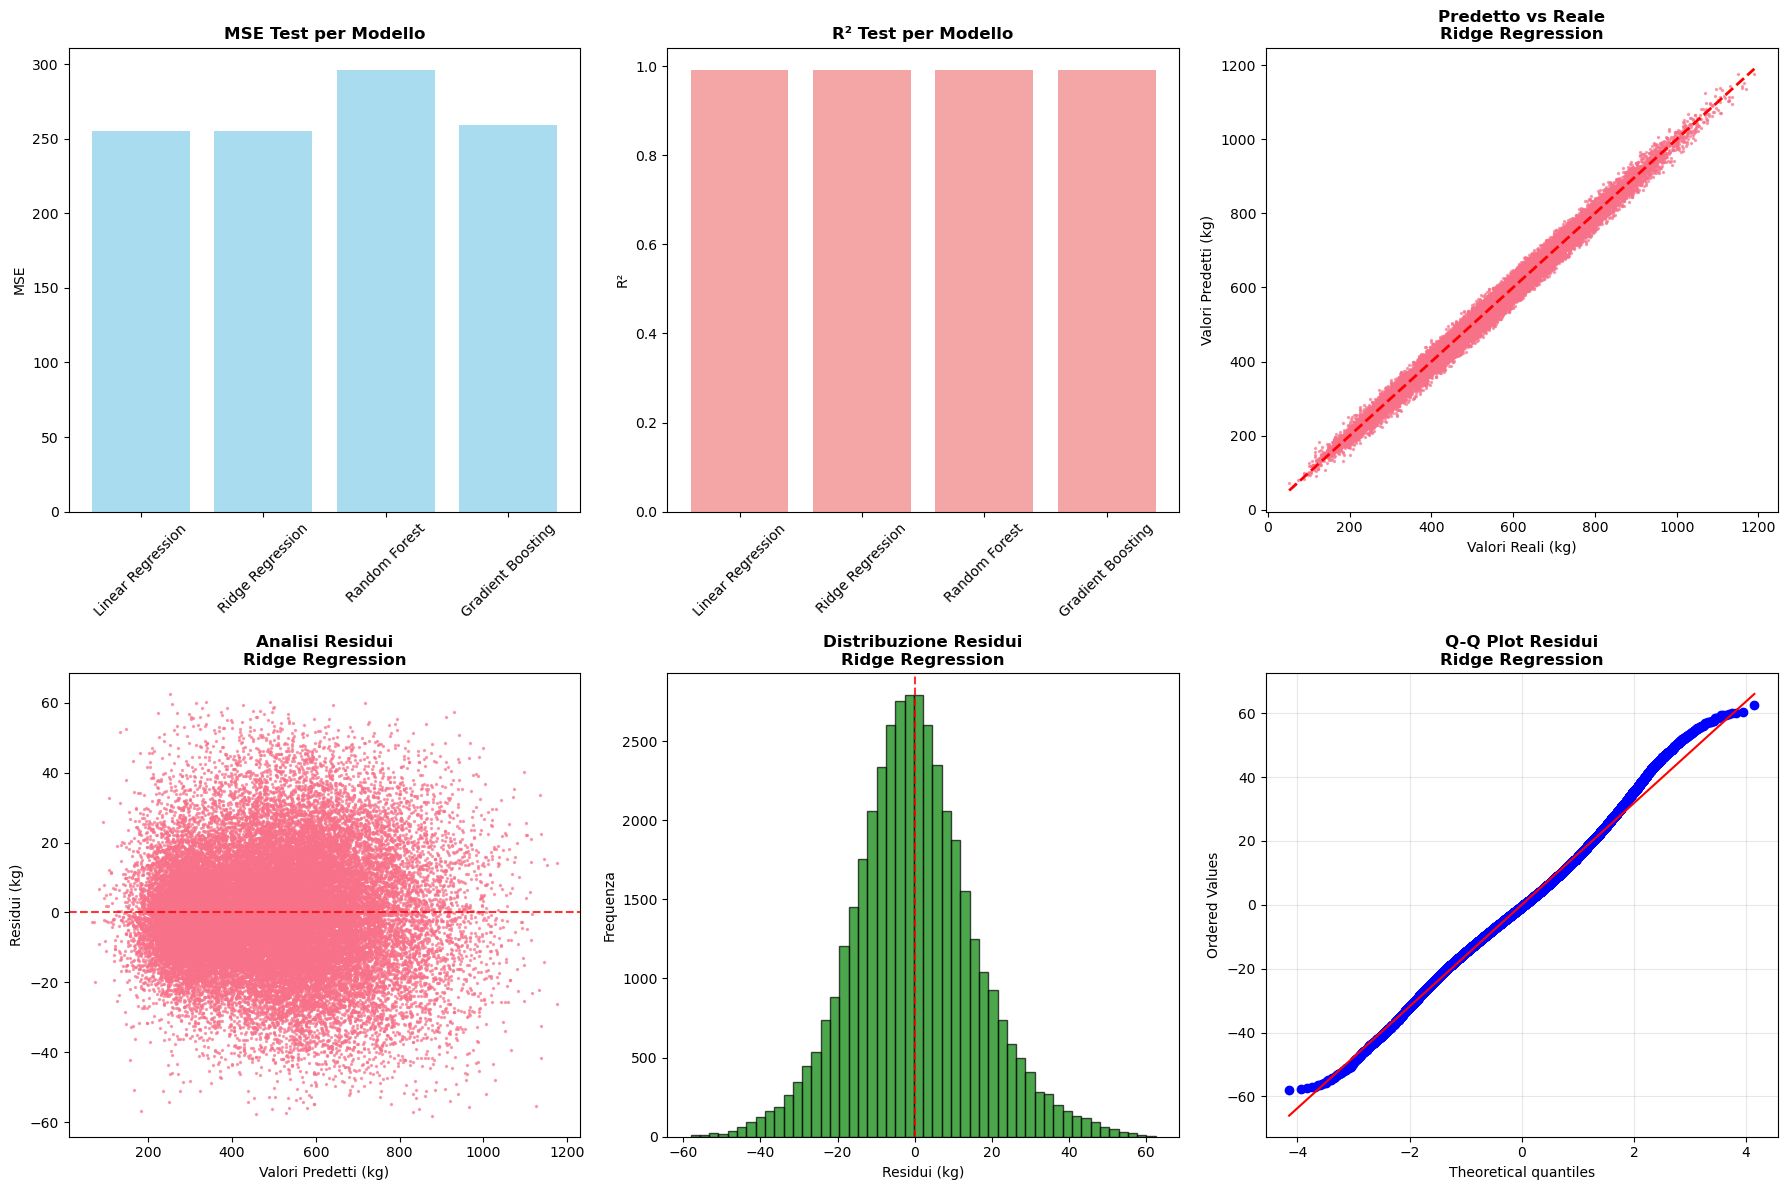


RISULTATI FINALI
Miglior modello: Ridge Regression
MSE Test: 255.0846
R² Test: 0.9918
RMSE Test: 15.9714

Statistiche Residui:
Media residui: 0.006912
Deviazione standard residui: 15.9714
Min residuo: -58.1261
Max residuo: 62.5166

Test di Shapiro-Wilk per normalità residui:
Statistica: 0.9940, p-value: 0.000000
I residui non seguono una distribuzione normale (p ≤ 0.05)


In [17]:
# Visualizzazioni finali
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
model_names = list(results.keys())
test_mses = [results[name]['test_mse'] for name in model_names]
test_r2s = [results[name]['test_r2'] for name in model_names]

# MSE Test per Modello
axes[0, 0].bar(model_names, test_mses, color='skyblue', alpha=0.7)
axes[0, 0].set_title('MSE Test per Modello', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].tick_params(axis='x', rotation=45)

# R² Test per Modello
axes[0, 1].bar(model_names, test_r2s, color='lightcoral', alpha=0.7)
axes[0, 1].set_title('R² Test per Modello', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('R²')
axes[0, 1].tick_params(axis='x', rotation=45)

# Predicted vs Actual per il miglior modello
axes[0, 2].scatter(y_test, final_best_predictions, alpha=0.6, s=2)
axes[0, 2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 2].set_xlabel('Valori Reali (kg)')
axes[0, 2].set_ylabel('Valori Predetti (kg)')
axes[0, 2].set_title(f'Predetto vs Reale\n{final_best_name}', fontsize=12, fontweight='bold')

# Residui del miglior modello
residuals = y_test - final_best_predictions
axes[1, 0].scatter(final_best_predictions, residuals, alpha=0.6, s=2)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 0].set_xlabel('Valori Predetti (kg)')
axes[1, 0].set_ylabel('Residui (kg)')
axes[1, 0].set_title(f'Analisi Residui\n{final_best_name}', fontsize=12, fontweight='bold')

# Distribuzione dei residui (istogramma)
axes[1, 1].hist(residuals, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', alpha=0.8)
axes[1, 1].set_xlabel('Residui (kg)')
axes[1, 1].set_ylabel('Frequenza')
axes[1, 1].set_title(f'Distribuzione Residui\n{final_best_name}', fontsize=12, fontweight='bold')

# Q-Q Plot per normalità dei residui
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title(f'Q-Q Plot Residui\n{final_best_name}', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

# Aggiustamento del layout
plt.tight_layout()
plt.show()

# Stampa statistiche finali
print("\n" + "="*60)
print("RISULTATI FINALI")
print("="*60)
print(f"Miglior modello: {final_best_name}")
print(f"MSE Test: {results[final_best_name]['test_mse']:.4f}")
print(f"R² Test: {results[final_best_name]['test_r2']:.4f}")
print(f"RMSE Test: {np.sqrt(results[final_best_name]['test_mse']):.4f}")

# Statistiche sui residui
print(f"\nStatistiche Residui:")
print(f"Media residui: {np.mean(residuals):.6f}")
print(f"Deviazione standard residui: {np.std(residuals):.4f}")
print(f"Min residuo: {np.min(residuals):.4f}")
print(f"Max residuo: {np.max(residuals):.4f}")

# Test di normalità sui residui
from scipy.stats import shapiro
stat, p_value = shapiro(residuals[:5000] if len(residuals) > 5000 else residuals)  # shapiro ha limite di 5000 campioni
print(f"\nTest di Shapiro-Wilk per normalità residui:")
print(f"Statistica: {stat:.4f}, p-value: {p_value:.6f}")
if p_value > 0.05:
    print("I residui sembrano seguire una distribuzione normale (p > 0.05)")
else:
    print("I residui non seguono una distribuzione normale (p ≤ 0.05)")

print("="*60)

# Conclusioni

Il modello Ridge Regression ha raggiunto performance eccellenti (R² = 0.992, RMSE ≈ 16 kg), confermando che le tre alzate individuali sono i predittori dominanti del totale. Tuttavia, l'elevata accuratezza statistica non deve oscurare i limiti significativi del dataset: mancano variabili antropometriche cruciali (altezza, composizione corporea), fattori situazionali (variabilità delle giurie, condizioni di gara) e aspetti psicologici che influenzano le performance reali.

Particolarmente interessante è la scarsa correlazione tra età e performance totale, visibile nella heatmap, suggerendo che nel powerlifting competitivo l'esperienza possa compensare gli effetti dell'invecchiamento. Nonostante i limiti, il modello mantiene valore pratico per stime baseline e analisi comparative, ma evidenzia la necessità di dati più ricchi per predizioni veramente affidabili nel contesto sportivo.

Il progetto dimostra che ottenere metriche statistiche eccellenti non garantisce automaticamente un modello robusto: la complessità multidimensionale del powerlifting richiede una raccolta dati più completa per catturare tutti i fattori determinanti la performance.